In [2]:
# import

import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
from torch import nn
from torch import optim

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
import optuna
from optuna.trial import TrialState
import os

import corner

device=torch.device(2 if torch.cuda.is_available() else 'cpu')
print(device)

cuda:2


**Processing the data**

In [3]:
BATCH_SIZE=1024
N_VARIABLE = 5
N_CONTEXT = 2

In [7]:
# Loading catalog
data_0 = torch.tensor([])
data_1 = torch.tensor([])
data_2 = torch.tensor([])
data_3 = torch.tensor([])
data_4 = torch.tensor([])
WDM_mass = torch.tensor([])
Omega_m = torch.tensor([])



wdm_ori =np.loadtxt('sobol_sequence_WDM_real_values.txt',usecols=[5])
Omega_m_ori = np.loadtxt('sobol_sequence_WDM_real_values.txt',usecols=[0])


data = [data_0,data_1,data_2,data_3,data_4,WDM_mass,Omega_m]
for num in range(0,1024):
    # catalogue name
    catalogue = 'WDM/WDM_'+str(num)+'/fof_subhalo_tab_018.hdf5'
    #catalogue = 'IllustrisTNG/LH_'+str(num)+'/fof_subhalo_tab_033.hdf5'

    # value of the scale factor
    scale_factor = 1.0
    # open the catalogue
    f = h5py.File(catalogue, 'r')
    
    data_0_temp = f['Subhalo/SubhaloStarMetallicity'][:]
    data_1_temp = f['Subhalo/SubhaloGasMetallicity'][:] 
    data_2_temp = f['Subhalo/SubhaloMassType'][:,0]*1e10
    data_3_temp = f['Subhalo/SubhaloMassType'][:,4]*1e10
    data_4_temp = f['Subhalo/SubhaloVmax'][:]
    
    WDM_mass_temp = torch.ones(len(data_0_temp))*wdm_ori[num]
    Omega_m_temp = torch.ones(len(data_0_temp))*Omega_m_ori[num]
    
    #data_3_temp = f['Subhalo/SubhaloStarMetallicity'][:] 
    
    # close file
    f.close()
    
    temp = [data_0_temp,data_1_temp,data_2_temp,data_3_temp,data_4_temp,WDM_mass_temp,Omega_m_temp]
    
    non_zero_M_star = temp[3]>2e8
    
    #selected_indice = torch.linspace(0,1200-1,1200,dtype=int)
    
    for i in range(0,N_VARIABLE+N_CONTEXT):
        temp[i] = np.array(temp[i][non_zero_M_star])
        #temp[i] = np.array(temp[i])
        #temp[i] = temp[i][selected_indice]
        if i<N_VARIABLE:
            temp[i] = np.log10(temp[i]*10**10+1)-10
            temp[i][temp[i]==-10]=0
        temp[i] = torch.tensor(temp[i], dtype=torch.float32)
        data[i] = torch.cat((data[i], temp[i]),0)
        #print(temp[i].max(),temp[i].min())
    


lense = len(data[0])



In [8]:
def normalizing(samples):
    n = samples.size(0)
    result = torch.zeros(samples.size())
    for i in range(n):
        result[i] = (samples[i]-torch.std_mean(samples,dim=1)[1][i])/torch.std_mean(samples,dim=1)[0][i]
    return result

In [9]:


rand_perm = torch.randperm(lense)

ori_data = torch.stack([data[i][rand_perm] for i in range(0,N_VARIABLE) ],dim=0)
ori_context = torch.stack([data[i][rand_perm] for i in range(N_VARIABLE,N_VARIABLE+N_CONTEXT) ],dim=0)

data_mean = torch.std_mean(ori_data,dim=1)[1]
data_std = torch.std_mean(ori_data,dim=1)[0]
norm_data = normalizing(ori_data)
print(norm_data)

context_mean = torch.std_mean(ori_context,dim=1)[1]
context_std = torch.std_mean(ori_context,dim=1)[0]
norm_context= normalizing(ori_context)

train_num = int(0.8*lense)-int(0.8*lense)%BATCH_SIZE
batch_num = int(train_num/BATCH_SIZE)
print(train_num)
train_indice = torch.linspace(0,train_num-1,train_num,dtype=int)
test_indice = torch.linspace(int(0.8*lense)+1,lense-1,lense-int(0.8*lense)-1,dtype=int)

source_data = torch.index_select(norm_data,1,train_indice)
source_context = torch.index_select(norm_context,1,train_indice)


train_data = torch.reshape(source_data,(N_VARIABLE,batch_num,BATCH_SIZE))
test_data = torch.index_select(norm_data,1,test_indice)
test_data = torch.t(test_data).to(device)

train_context = torch.reshape(source_context,(N_CONTEXT,batch_num,BATCH_SIZE))
test_context = torch.index_select(norm_context,1,test_indice)
test_context = torch.t(test_context).to(device)

print(data_mean)
print(context_mean)
#print(test_data)

tensor([[-2.2115, -1.4879, -0.2760,  ...,  0.7552, -0.0324, -0.0513],
        [-1.7361, -1.1809, -0.1491,  ...,  0.6456,  0.3483, -0.0510],
        [ 0.7405,  0.1714, -0.7396,  ...,  0.7076, -0.4389, -0.2194],
        [-0.9795, -0.2105, -0.6447,  ...,  1.1605, -0.3164, -0.6520],
        [ 0.5527, -1.7158, -0.2549,  ...,  0.9082, -0.5095, -1.8019]])
115712
tensor([-2.4081, -2.2801,  9.9064,  8.7988,  2.2022])
tensor([0.3073, 0.3741])


In [ ]:
train = torch.cat([source_data,source_context],dim=0)
print(train.size())
torch.save(train,'./data/WDM_con_train.pt')

test = torch.cat([torch.t(test_data),torch.t(test_context)],dim=0)
torch.save(test,'./data/WDM_con_test.pt')


In [10]:
train = torch.load('./data/WDM_con_train.pt')
test = torch.load('./data/WDM_con_test.pt')
source_data = train[:5]
source_context = train[5:]
test_data = torch.t(test[:5])
test_context = torch.t(test[5:])

lense = len(train[0])+len(test[0])
train_num = int(0.8*lense)-int(0.8*lense)%BATCH_SIZE
batch_num = int(train_num/BATCH_SIZE)
print(train_num)

115712


Create and Train the model

In [11]:
# Create the model

num_layers = 5
input_dim = N_VARIABLE
context_dim = N_CONTEXT

base_dist = dist.Normal(torch.zeros(input_dim).to(device), torch.ones(input_dim).to(device))
transform = []
for i in range(0,num_layers):
    transform.append(T.conditional_spline_autoregressive(input_dim,context_dim, count_bins=2,bound=3).to(device))
flow = dist.ConditionalTransformedDistribution(base_dist, transform)


In [12]:

num_iter = 10
lr = 0.001
weight_decay = 0.002

optimizer = optim.Adam((par for model in transform for par in model.parameters()),lr = lr,weight_decay = weight_decay )


for i in range(0,num_iter):
        rand_train = torch.randperm(train_num)
        for j in range(0,N_VARIABLE):
            source_data[j] = source_data[j][rand_train] 
        train_data = torch.reshape(source_data,(N_VARIABLE,batch_num,BATCH_SIZE))
                
        for j in range(0,N_CONTEXT):
            source_context[j] = source_context[j][rand_train] 
        train_context = torch.reshape(source_context,(N_CONTEXT,batch_num,BATCH_SIZE))

        # batch loop:
        for num in range(batch_num):
            x = torch.stack([train_data[j][num%(batch_num)] for j in range(0,N_VARIABLE)],dim=0)
            x = torch.t(x)
            x = x.to(device)
            
            y = torch.stack([train_context[j][num%(batch_num)] for j in range(0,N_CONTEXT)],dim=0)
            y = torch.t(y)
            y = y.to(device)
            
            optimizer.zero_grad()
            loss = -flow.condition(y.detach()).log_prob(x.detach()).mean()
            loss.backward()
            optimizer.step()
            flow.clear_cache()
        
        with torch.no_grad():
            error = -flow.condition(test_context).log_prob(test_data).mean()
            print(error)

tensor(3.0076, device='cuda:2')
tensor(2.7082, device='cuda:2')
tensor(2.5746, device='cuda:2')
tensor(2.5142, device='cuda:2')


KeyboardInterrupt: 

In [5]:
flow = torch.load('models/reverse/reverse_con_2_155.pt',map_location=device)
#torch.save(flow, 'models/test & best/WDM_con_z=5_rev.pt')

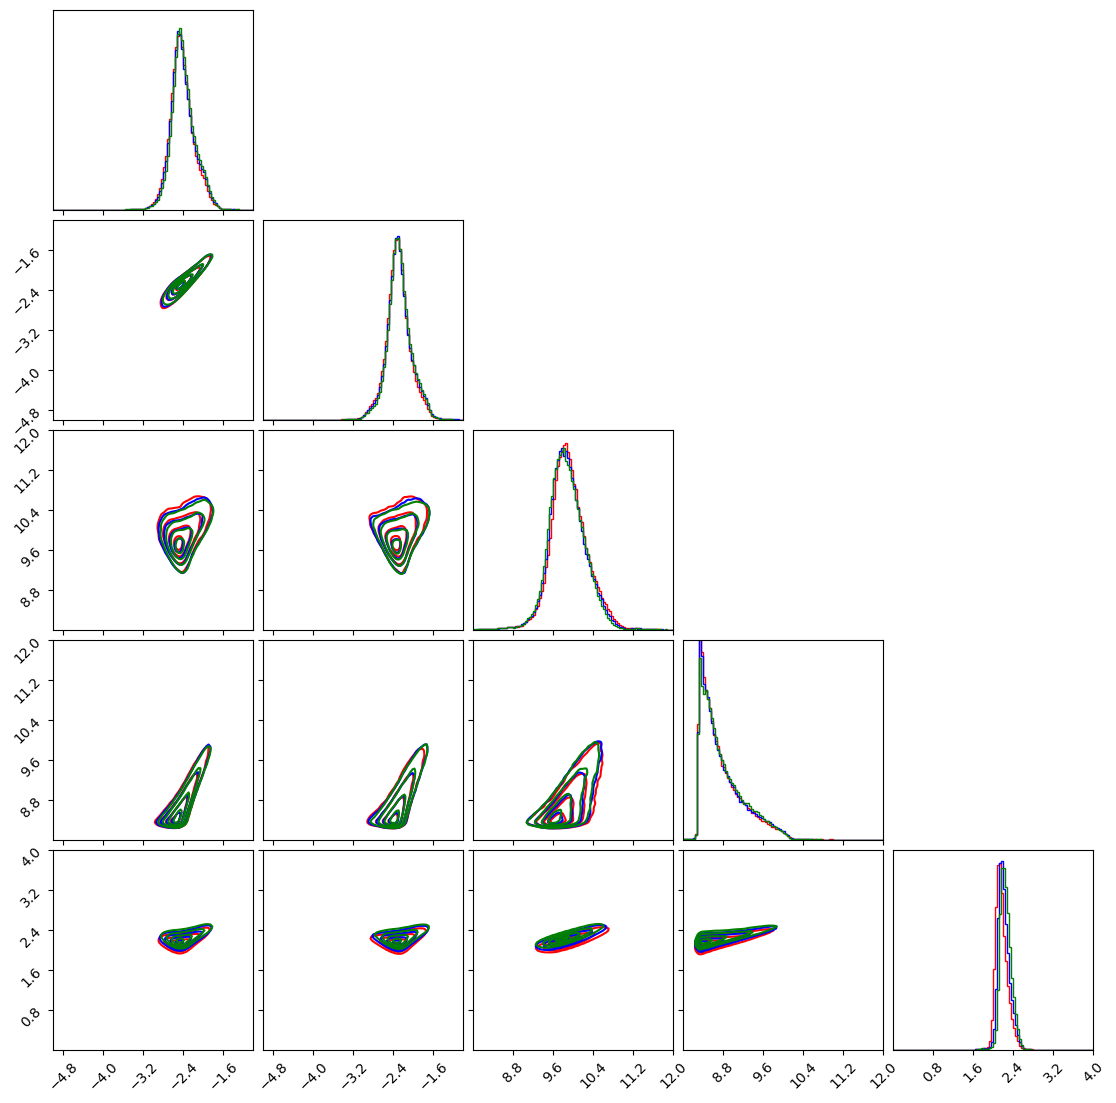

In [14]:
sam_context_val = [[0.4,0.3],[0.4,0.4],[0.4,0.5]]
color = ['red','blue','green']
sam_context_val = torch.tensor(sam_context_val)
n_samples = 100000
samples = []

for i in sam_context_val:
    sam_context = (i-context_mean)/context_std
    sam_context = sam_context.repeat([n_samples,1]).to(device)

    sam_temp = flow.condition(sam_context).sample([n_samples]).to('cpu')
    sam_temp = sam_temp*data_std+data_mean
    samples.append(sam_temp)
#print(samples)

BINS = 100
corner_sam = samples[0].numpy()
fig = corner.corner(
            #corner_samples, 
            corner_sam,
            #labels=['Gas Mass','Gas Metalicity','stellar Mass','stellar Metalicity','1/WDM_mass'],
            plot_datapoints = False,
            plot_density=False,
            color='red',
            bins = BINS,
            weights=np.ones(len(corner_sam))/len(corner_sam),
            range = [(-5,-1),(-5,-1),(8,12),(8,12),(0,4)],
            #range = [(6.8,11),(-0.2,0.2),(-0.2,0.2),(-0.2,0.2)],
            smooth=1,
            alpha = 0.7
        )
for i in range(1,len(samples)):
    corner_sam = samples[i].numpy()
    #print(i.numpy())
    fig = corner.corner(
            #corner_samples, 
            samples[i].numpy(),
            #labels=['Gas Mass','Gas Metalicity','stellar Mass','stellar Metalicity','1/WDM_mass'],
            plot_datapoints = False,
            plot_density=False,
            color=color[i],
            bins = BINS,
            weights=np.ones(len(corner_sam))/len(corner_sam),
            range = [(-5,-1),(-5,-1),(8,12),(8,12),(0,4)],
            #range = [(6.8,11),(-0.2,0.2),(-0.2,0.2),(-0.2,0.2)],
            smooth=1,
            fig = fig,
            alpha = 0.7
        )

In [14]:
# DRP
n1 = 1024
n2 = 1024

def DRP(alpha):
    sim_indice = torch.linspace(0,n1-1,n1,dtype=int)
    sim_data = torch.index_select(norm_data,1,sim_indice)
    sim_data = torch.t(sim_data).to(device)
    
    sim_context = torch.index_select(norm_context,1,sim_indice)
    sim_context = torch.t(sim_context).to(device)
    #print(sim_context.size())
    
    sim_1 = sim_data.repeat([n2,1,1])
    
    context_ref = sim_context[0].repeat([n1,1])
    sim_ref = flow.condition(context_ref).sample([n1])
    sim_ref = sim_ref.repeat([n2,1,1])
    
    context_2 = sim_context.repeat([n2,1])
    sim_2 = flow.condition(context_2).sample([n1*n2])
    sim_2 = torch.reshape(sim_2,[n2,n1,N_VARIABLE])

    dis_1 = torch.norm(sim_1-sim_ref,dim = -1)
    dis_2 = torch.norm(sim_2-sim_ref,dim = -1)

    num = dis_2<dis_1
    #print(num)
    f = torch.mean(num.to(torch.float32),dim = 0)
    result = f<1-alpha
    result = result.to(torch.float32)
    return result.mean().to('cpu').numpy()

DRP(0.6)

x = np.linspace(0,1,20)
y = np.array([DRP(i) for i in x])
plt.plot(1-x,y-1+x)
#plt.plot(x,x)
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x4 and 6x20)

Reverse model

In [31]:
# Create the reverse model

num_layers = 5
input_dim = N_CONTEXT
context_dim = N_VARIABLE

base_dist = dist.Normal(torch.zeros(input_dim).to(device), torch.ones(input_dim).to(device))
transform = []
for i in range(0,num_layers):
    transform.append(T.conditional_spline_autoregressive(input_dim,context_dim, count_bins=2,bound=3).to(device))
flow = dist.ConditionalTransformedDistribution(base_dist, transform)


In [32]:
num_iter = 10
lr = 0.001
weight_decay = 0.002

optimizer = optim.Adam((par for model in transform for par in model.parameters()),lr = lr,weight_decay = weight_decay )


for i in range(0,num_iter):
        rand_train = torch.randperm(train_num)
        for j in range(0,N_VARIABLE):
            source_data[j] = source_data[j][rand_train] 
        train_data = torch.reshape(source_data,(N_VARIABLE,batch_num,BATCH_SIZE))
                
        for j in range(0,N_CONTEXT):
            source_context[j] = source_context[j][rand_train] 
        train_context = torch.reshape(source_context,(N_CONTEXT,batch_num,BATCH_SIZE))

        # batch loop:
        for num in range(batch_num):
            x = torch.stack([train_data[j][num%(batch_num)] for j in range(0,N_VARIABLE)],dim=0)
            x = torch.t(x)
            x = x.to(device)
            
            y = torch.stack([train_context[j][num%(batch_num)] for j in range(0,N_CONTEXT)],dim=0)
            y = torch.t(y)
            y = y.to(device)
            
            optimizer.zero_grad()
            loss = -flow.condition(x.detach()).log_prob(y.detach()).mean()
            loss.backward()
            optimizer.step()
            flow.clear_cache()
        
        with torch.no_grad():
            error = -flow.condition(test_data).log_prob(test_context).mean()
            print(error)

tensor(2.1419, device='cuda:2')
tensor(2.0367, device='cuda:2')
tensor(1.9453, device='cuda:2')
tensor(1.8930, device='cuda:2')
tensor(1.8690, device='cuda:2')
tensor(1.8438, device='cuda:2')
tensor(1.8449, device='cuda:2')
tensor(1.8246, device='cuda:2')
tensor(1.8170, device='cuda:2')
tensor(1.8144, device='cuda:2')


In [21]:
print(test_data[0])

tensor([-0.5829, -0.5524, -0.5220, -0.8608, -0.6135], device='cuda:2')


tensor([[ 0.4615, -0.2097,  1.0147,  0.8826,  1.3113],
        [ 0.4270,  0.2617, -0.2426, -0.0103, -0.3168],
        [ 1.5691,  1.5336,  0.9309,  1.8155,  0.8720],
        [-0.1775, -0.1720, -0.1475, -0.3749, -1.1759],
        [ 0.2894,  0.5069, -0.4595,  0.0824, -0.1553],
        [ 0.8284,  0.6134,  1.0024,  1.1122,  0.7333],
        [-0.1538, -0.5567,  0.3975,  0.3980,  0.9322],
        [-1.5604, -1.0442, -0.0226, -0.9940, -0.7073],
        [ 0.0880,  0.2684, -0.4260, -0.2387, -0.4186],
        [-1.3120, -1.3237,  0.9592, -0.2778,  0.8319],
        [-0.6328, -1.0182,  0.7630,  0.0899,  0.9321],
        [ 2.7069,  2.6125,  1.1800,  2.8861,  2.2918],
        [-0.4187, -0.2241, -1.0406, -1.0830, -1.1852],
        [ 1.4357,  1.1152, -1.9309, -0.4058, -0.1389],
        [-0.8173, -1.5212, -0.2861, -0.9818,  0.2929],
        [-0.7833, -1.3635,  1.1309, -0.0088,  1.6693],
        [ 0.0298,  0.0881, -0.4368, -0.6320, -0.4184],
        [ 0.0334,  0.1077, -1.6667, -0.8627, -1.0471],
        [-

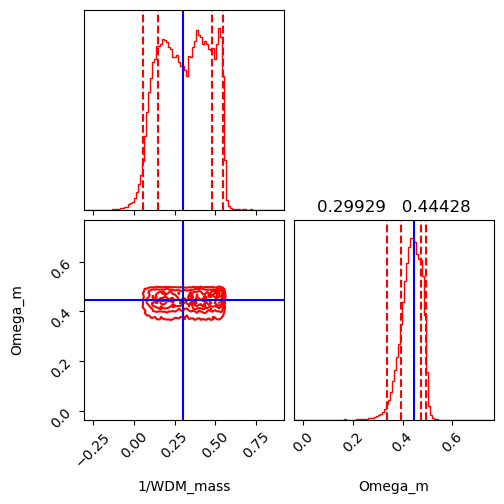

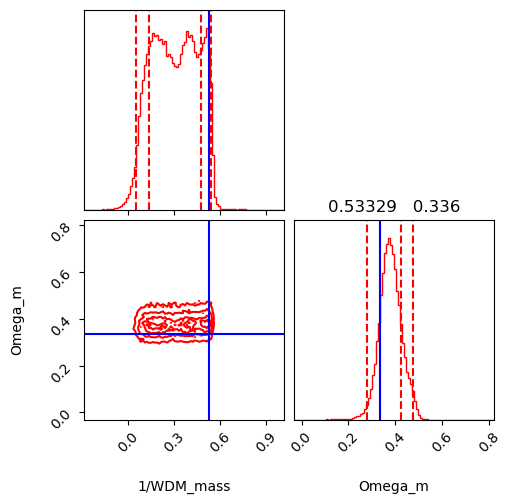

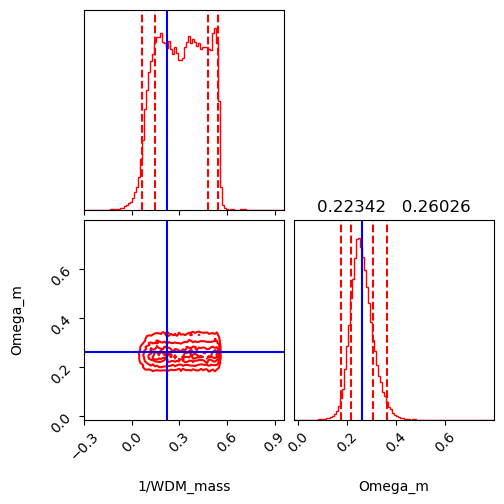

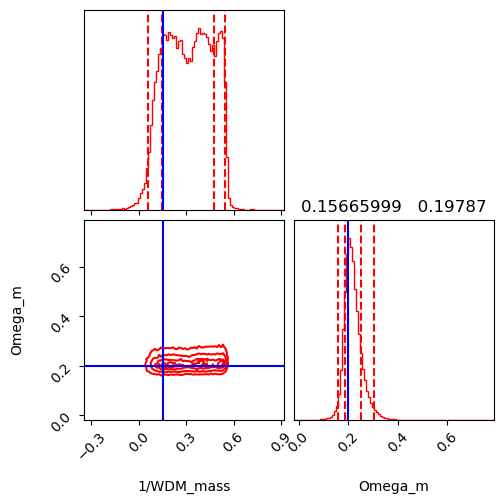

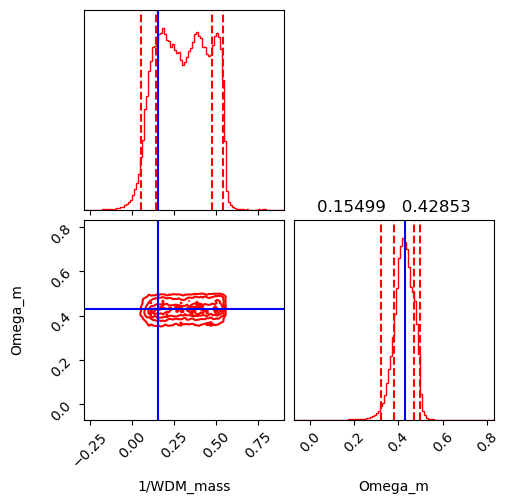

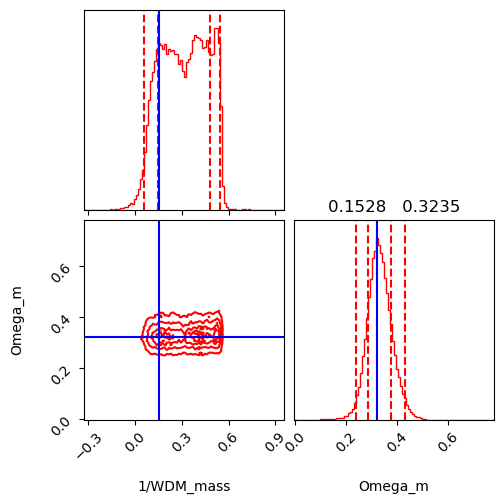

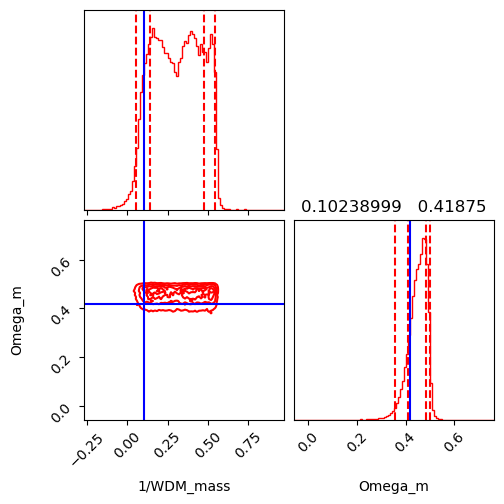

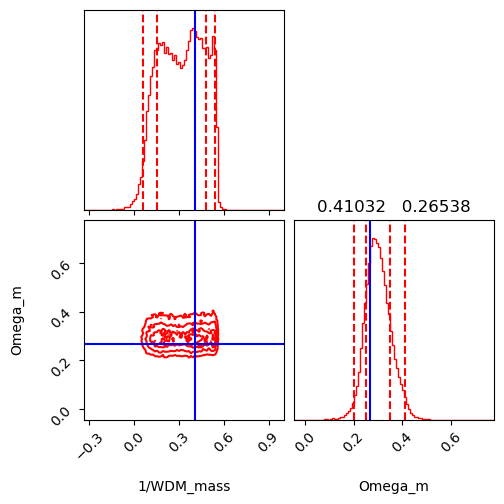

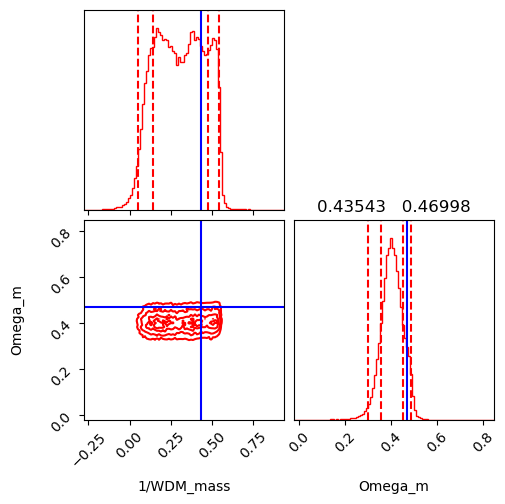

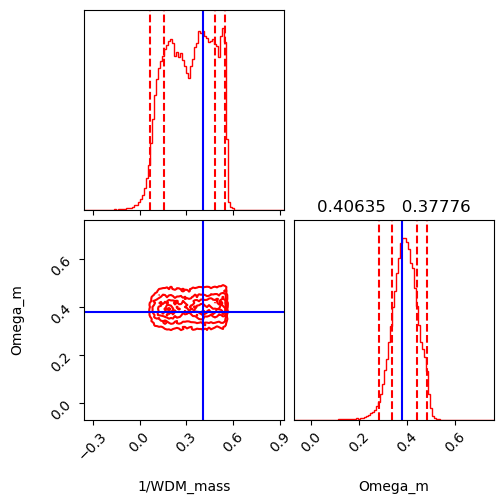

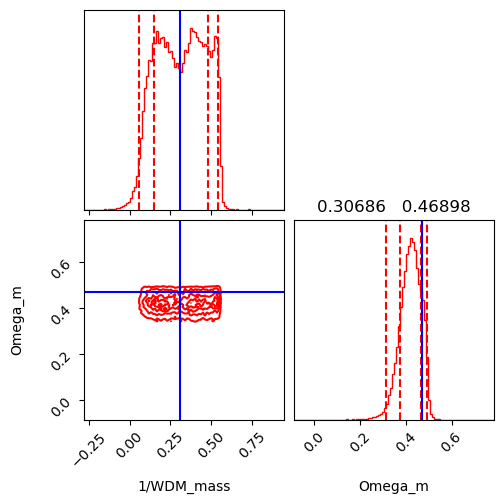

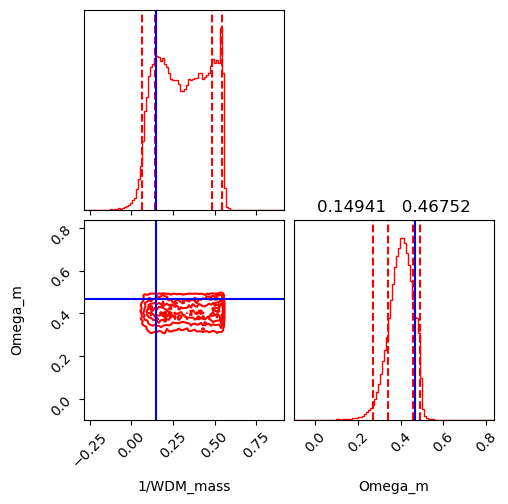

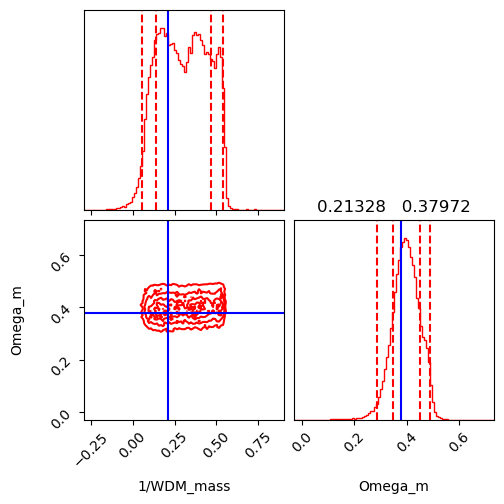

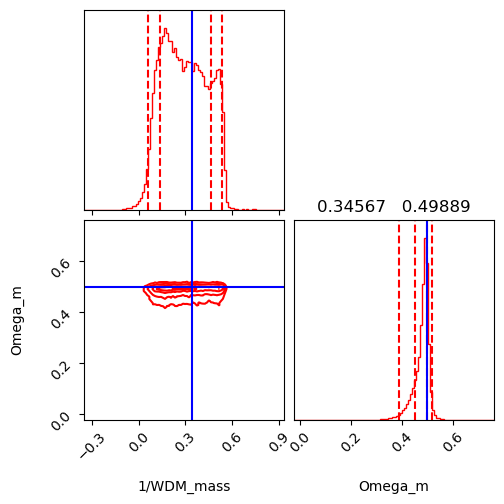

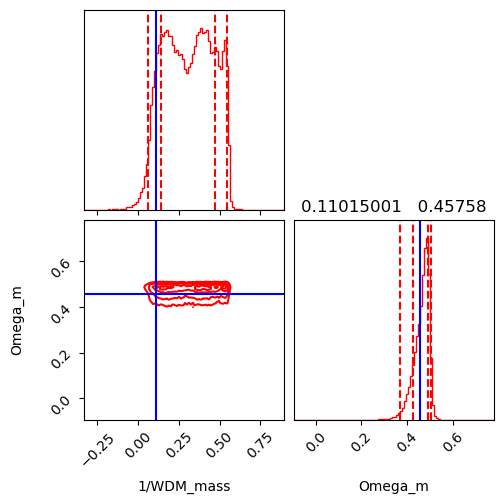

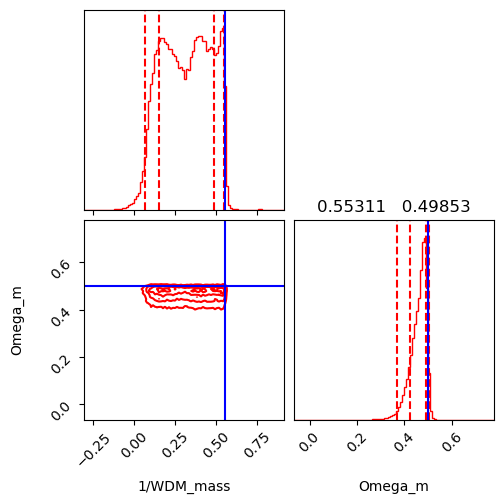

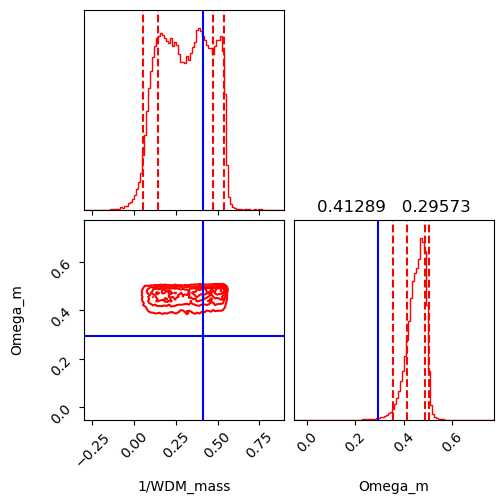

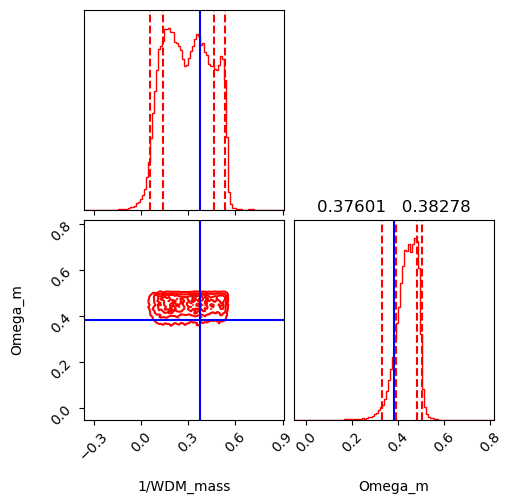

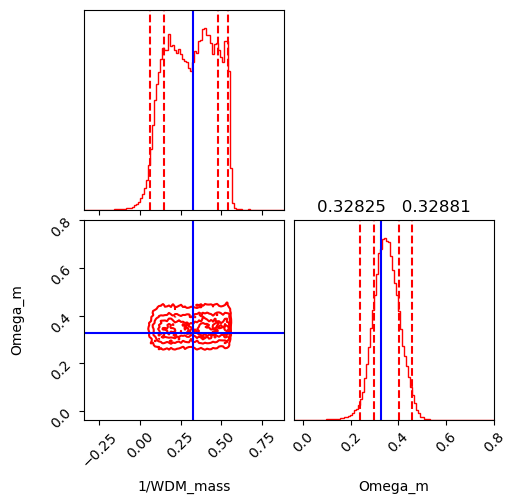

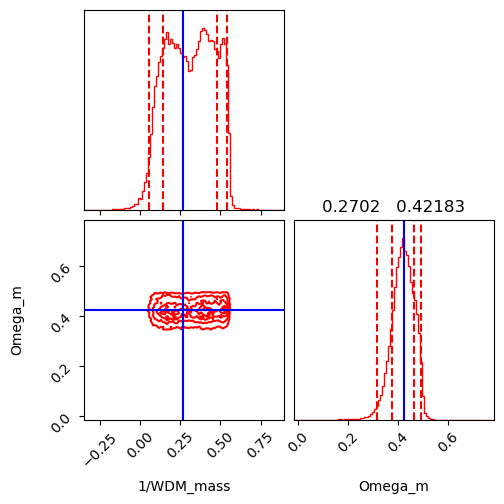

In [38]:
#sam_id = [50,300,450]
#sam_context_val = torch.stack([test_data[50],test_data[300]])
#print((test_context[50].to('cpu')*context_std)+context_mean,test_context[300])
sam_id = np.random.randint(1,len(test[0]),20)
sam_context_val = torch.stack([test_data[i] for i in sam_id],dim = 0)
print(sam_context_val)
true_value = [(test_context[i].to('cpu')*context_std)+context_mean for i in sam_id]
true_data = (sam_context_val.to('cpu')*data_std)+data_mean
print(true_value)
n_samples = 100000
samples = []

for i in sam_context_val:
    #sam_context = (i-data_mean)/data_std
    sam_context = i
    sam_context = sam_context.repeat([n_samples,1]).to(device)

    sam_temp = flow.condition(sam_context).sample([n_samples]).to('cpu')
    sam_temp = sam_temp*context_std+context_mean
    samples.append(sam_temp)
#print(samples)

BINS = 100

for i in range(0,len(sam_id)):
    sam = samples[i].numpy()
    #print(i.numpy())
    fig = corner.corner(
            #corner_samples, 
            sam,
            labels=['1/WDM_mass','Omega_m'],
            plot_datapoints = False,
            plot_density=False,
            color='red',
            bins = BINS,
            weights=np.ones(len(sam))/len(sam),
            quantiles=(0.025,0.16, 0.84,0.975),
            #range = [(-5,-1),(-5,-1),(8,12),(8,12)],
            #range = [(6.8,11),(-0.2,0.2),(-0.2,0.2),(-0.2,0.2)],
            #smooth=1,
            alpha = 0.7,
        )
    plt.title(str(true_value[i][0].numpy())+'   '+str(true_value[i][1].numpy()))
    corner.overplot_lines(fig, true_value[i].numpy(), color='blue')

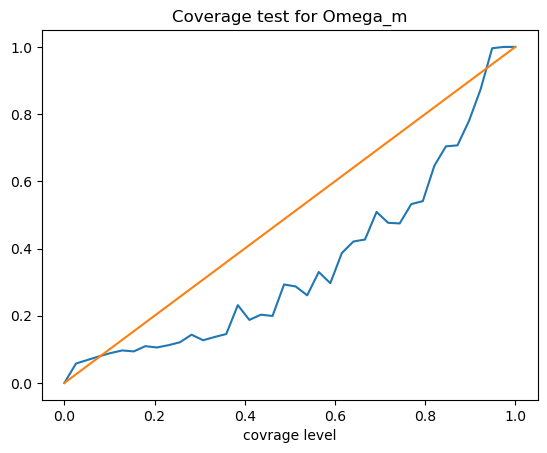

In [40]:
# DRP
n1 = 1024
n2 = 1024

def DRP(alpha):
    sim_indice = torch.linspace(0,n1-1,n1,dtype=int)
    sim_data = torch.index_select(norm_context,1,sim_indice)
    sim_data = torch.t(sim_data[1]).to(device)
    #sim_data = torch.t(sim_data).to(device)
    
    sim_context = torch.index_select(norm_data,1,sim_indice)
    sim_context = torch.t(sim_context).to(device)
    #print(sim_context.size())
    
    sim_1 = sim_data.repeat([n2,1,1])
    
    #context_ref = sim_context[0].repeat([n1,1])
    context_ref = sim_context[torch.randperm(n1)]
    sim_ref = flow.condition(context_ref).sample([n1])
    sim_ref = sim_ref[:,1]
    sim_ref = sim_ref.repeat([n2,1,1])
    
    
    context_2 = sim_context.repeat([n2,1])
    sim_2 = flow.condition(context_2).sample([n1*n2])
    #sim_2 = torch.reshape(sim_2,[n2,n1,N_CONTEXT])
    sim_2 = sim_2[:,1]
    sim_2 = torch.reshape(sim_2,[n2,n1,N_CONTEXT-1])


    
    dis_1 = torch.norm(sim_1-sim_ref,dim = -1)
    dis_2 = torch.norm(sim_2-sim_ref,dim = -1)

    num = dis_2<dis_1
    #print(num)
    f = torch.mean(num.to(torch.float32),dim = 0)
    result = f<1-alpha
    result = result.to(torch.float32)
    return result.mean().to('cpu').numpy()

#DRP(0.6)

x = np.linspace(0,1,40)
y = np.array([DRP(i) for i in x])
plt.xlabel('covrage level')
plt.plot(1-x,y)
plt.plot(1-x,1-x)
plt.title('Coverage test for Omega_m')
plt.show()